## Code from ProjC2 - Baseline


In [1]:
import numpy as np
import importlib
import fncs
import matplotlib.pyplot as plt
import random
import pandas as pd

importlib.reload(fncs)

<module 'fncs' from '/home/gathomp3/Deep_Learning/NNs/fncs.py'>

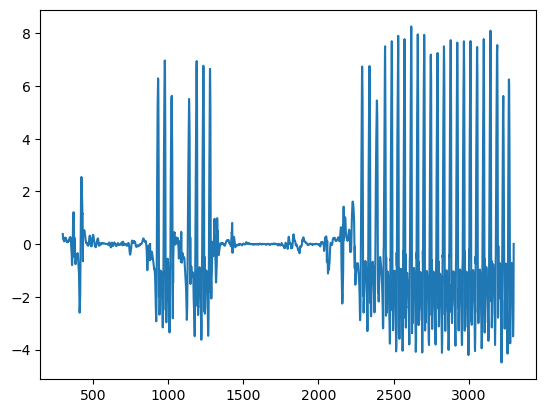

In [2]:
X_trial_path = "./GaitData/data/train/Trial01_x.csv"
x_trial_temp = pd.read_csv(X_trial_path, header=None)
plt.plot(x_trial_temp.iloc[300:3300,4])

### Loading the Data and Features

First, we define a helper function to load the data and compute the features. Take a look at how the labels are extracted by following a similar procedure for window extraction and assigning the mode.

In [3]:
# It loads the data and extracts the features
def loadFeatures(dataFolder,winSz,timeStep,idList):
    for k,id in enumerate(idList):
        # Loading the raw data
        xt, xv, yt, yv = fncs.loadTrial(dataFolder,id=id)

        # Extracting the time window for which we have values for the measurements and the response
        timeStart = np.max((np.min(xt),np.min(yt)))
        timeEnd = np.min((np.max(xt),np.max(yt)))

        # Extracting the features
        x_times, feat = fncs.extractFeat(xt,xv,winSz,timeStart,timeEnd,timeStep)
        y_times, lab = fncs.extractLabel(yt,yv,winSz,timeStart,timeEnd,timeStep)

        # Storing the features
        if(k==0):
            featList = feat
            labList = lab
        else:
            featList = np.concatenate((featList,feat),axis=0)
            labList = np.concatenate((labList,lab),axis=0)

    return featList, labList, x_times, y_times

Extracting the features for the training data and splitting it into training / validation. I will extract all training data then split in order to get the most balanced data possible.

In [4]:
# Specifying the data directory
dirTrain = './GaitData/data/train/'

# Specifying some parameters for the feature extraction
# I will leave these alone for now
timeStep = 1
winSz = 3

# Specifying IDs for training set
trainIDs = list(set(np.array(range(29))+1))

# Recovering the features and labels
X, y, X_times, y_times = loadFeatures(dirTrain,winSz,timeStep,trainIDs)

In [5]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# This function produces a summary of performance metrics including a confusion matrix
def summaryPerf(yTrain,yTrainHat,y,yHat):
    # Plotting confusion matrix for the non-training set:
    cm = metrics.confusion_matrix(y,yHat,normalize='true')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=
                                  ['Walk Hard','Down Stairs','Up Stairs','Walk Soft'])
    disp.plot()

    # Displaying metrics for training and non-training sets
    print('Training:  Acc = {:4.3f}'.format(metrics.accuracy_score(yTrain,yTrainHat)))
    print('Non-Train: Acc = {:4.3f}'.format(metrics.accuracy_score(y,yHat)))
    print('Training:  BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(yTrain,yTrainHat)))
    print('Non-Train: BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(y,yHat)))

### Class Imbalance - Need to do *something* about it

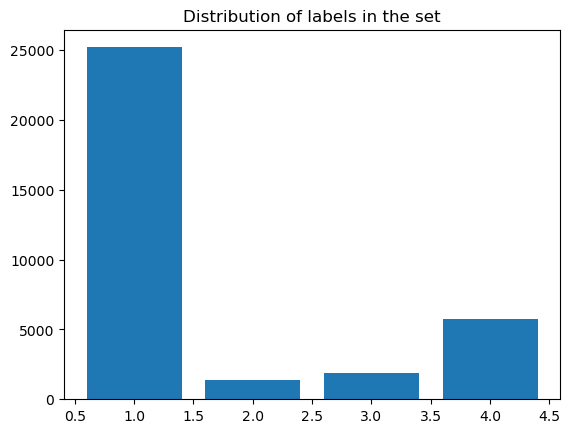

In [6]:
plt.bar([1,2,3,4],np.unique(y,return_counts=True)[1])
plt.title('Distribution of labels in the set')
plt.show()

## Trying synthetic data

In [7]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# fit predictor and target 
variablex_ros, y_ros = ros.fit_resample(X, y)

In [8]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(variablex_ros, y_ros, test_size=0.33, random_state=42)

Checking distr. of labels in training/validation.


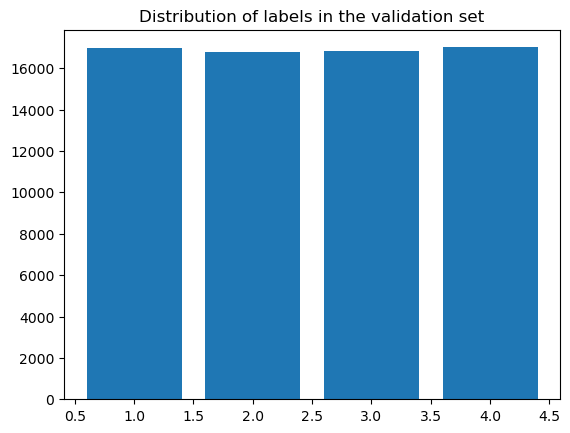

In [130]:
plt.bar([1,2,3,4],np.unique(y_train,return_counts=True)[1])
plt.title('Distribution of labels in the validation set')
plt.show()

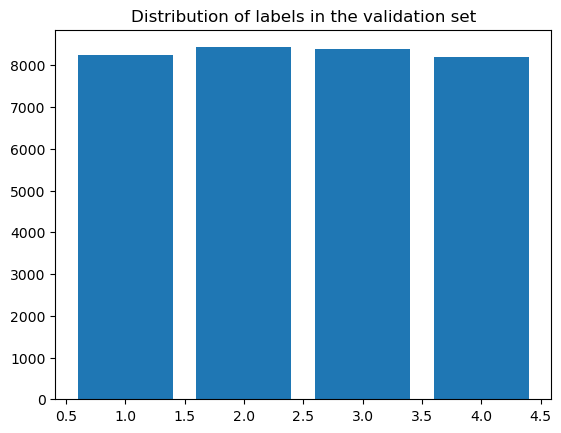

In [131]:
plt.bar([1,2,3,4],np.unique(y_val,return_counts=True)[1])
plt.title('Distribution of labels in the validation set')
plt.show()

Do I standard scale? I'm not even sure what the features are...

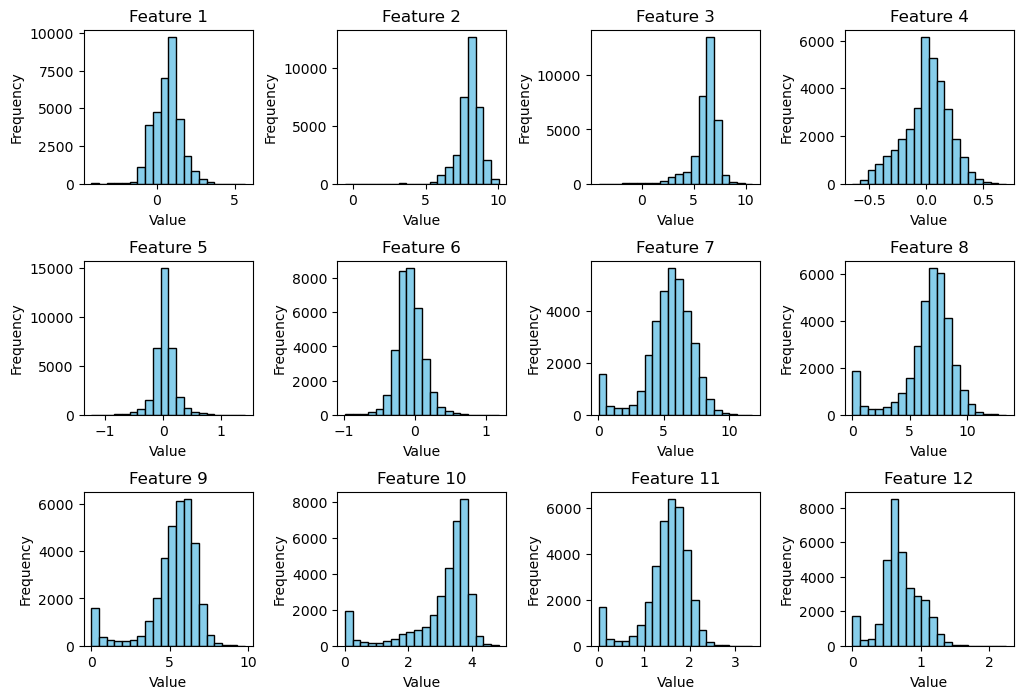

In [132]:
# Create subplots for each feature
fig, axs = plt.subplots(3, 4, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

# Flatten the axs array for easier iteration
axs_flat = axs.flatten()

# Plot histogram for each feature
for i, ax in enumerate(axs_flat):
    ax.hist(X[:, i], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Feature {i+1}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Hide any remaining empty subplots
for j in range(len(X[0]), len(axs_flat)):
    fig.delaxes(axs_flat[j])

## FROM PYTORCH TUTORIAL

Defines a network.

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
# Creating a wrapper so we have the same interface for all the methods. This wrapper takes as an
# input an mlp model so we can reuse it with different model architectures.
class NetWrapper:
  def __init__(self,model,device,epochs,cross_entropy_weights,optimizer,lr=1e-3, momentum=0.9, weight_decay=0.0):
    self.model = model.to(device)
    self.loss_fn = nn.CrossEntropyLoss(weight = torch.tensor(cross_entropy_weights).to(device))
    
    # Allows for optimizer, lr to be tuned
    if optimizer.lower() == 'adam' or optimizer == None:
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr, weight_decay=weight_decay)
    elif optimizer.lower() == 'sgd':
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr, momentum=momentum)
    
    self.device = device
    self.epochs = epochs

    self.loss_history = []
    self.val_loss_history = []


  def train_loop(self, dataloader, batch_size, val_dataloader=None,conv=False):
    size = len(dataloader.dataset)
    self.model.train()
    loss_count = 0
    for batch, (X_batch, y_batch) in enumerate(dataloader,1):
        size = len(dataloader.dataset)
        # Compute Prediction, Loss
        if conv: X_batch = X_batch.unsqueeze(1)
        pred = self.model(X_batch)
        loss = self.loss_fn(pred, y_batch)

        # Zero gradients, perform a backward pass, and update
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        loss_count += loss.item()
    loss_count/=(batch)
    self.loss_history.append(loss_count)
    
    print(f"loss: {loss_count:>8f}")
    if val_dataloader:
      with torch.no_grad():
        val_loss_count = 0
        for batch, (X_batch, y_batch) in enumerate(val_dataloader, 1):
          if conv: X_batch = X_batch.unsqueeze(1)
          pred = self.model(X_batch)
          val_loss = self.loss_fn(pred, y_batch)
          val_loss_count += val_loss.item()
        val_loss_count/=(batch)
        print(f"val_loss: {val_loss_count:>8f}")
        self.val_loss_history.append(val_loss_count)

  def fit(self, dataloader, batch_size, val_dataloader=None, conv=False):
    for i in range(self.epochs):
      print(f"Epoch {i+1}\n-------------------------------")
      self.train_loop(dataloader, batch_size, val_dataloader=val_dataloader, conv=conv)
    print("Done!")

  def test_loop(self, dataloader):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    self.model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = self.model(X)
            test_loss += self.loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100*correct, test_loss)


  def get_yhat(self, dataloader, conv=False):
    self.model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    y_hat = []

    with torch.no_grad():
        for X, y in dataloader:
            if conv: X = X.unsqueeze(1)
            pred = self.model(X)
            y_hat.extend(pred.argmax(1).cpu().numpy())

    return y_hat

  def plot_loss(self):
    plt.plot(self.loss_history, label='Training Loss')
    plt.plot(self.val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

### Define FCN 3-layer network.

In [134]:
class Net3(nn.Module):
    def __init__(self, num_features=12, neurons_1 = 64, neurons_2 = 32, num_classes=4):
        super().__init__()
        self.fc1 = nn.Linear(num_features, neurons_1)  # Adjust input size to match the number of features (12)
        self.fc2 = nn.Linear(neurons_1, neurons_2)
        self.fc3 = nn.Linear(neurons_2, num_classes)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net3 = Net3()
print(net3)

Net3(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


In [135]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


## Preprocessing

In [136]:
# Weights for the loss function scaled by class
class_distribution = np.unique(y_train, return_counts=True)[1]
scale_factor = 2
weights = (scale_factor*(1/class_distribution)/np.linalg.norm(1/class_distribution)).tolist()

In [137]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# REMOVE IF NECESSARY
# Trying to not bias too heavily against majority class
# weights[0] += .06

# Convert the data to PyTorch tensors and move to the device
# using the code from baseline 2

# SCALE DATA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train = torch.from_numpy(X_train).float()
X_train = X_train.to(device)
y_train = torch.from_numpy(y_train).long()
y_train = y_train.to(device)

X_val = torch.from_numpy(X_val).float()
X_val = X_val.to(device)
y_val = torch.from_numpy(y_val).long()
y_val = y_val.to(device)

# Creates a dataset object and dataloader objects
dataset_train = TensorDataset(X_train, y_train)
dataset_val = TensorDataset(X_val, y_val)

batch_size = 64

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [138]:
weights

[0.9957812272558583,
 1.0065804277897974,
 1.0044855050941535,
 0.9930883444543434]

### Learning Rate Search

In [139]:
lrs = np.geomspace(0.0001, 0.1, num=10)

models = []
for lr in lrs:
    net = Net3()
    net.to(device)
    netWrapper = NetWrapper(net, device, 90, weights, 'sgd', lr=lr, momentum=0.9)
    netWrapper.fit(dataloader_train, batch_size, val_dataloader=dataloader_val)
    models.append((netWrapper, lr, np.sum(netWrapper.val_loss_history[-4:])/4.0))


Epoch 1
-------------------------------
loss: 1.356128
val_loss: 1.317529
Epoch 2
-------------------------------
loss: 1.275295
val_loss: 1.225336
Epoch 3
-------------------------------
loss: 1.170876
val_loss: 1.106595
Epoch 4
-------------------------------
loss: 1.042029
val_loss: 0.968286
Epoch 5
-------------------------------
loss: 0.902778
val_loss: 0.831946
Epoch 6
-------------------------------
loss: 0.778200
val_loss: 0.722719
Epoch 7
-------------------------------
loss: 0.685868
val_loss: 0.647505
Epoch 8
-------------------------------
loss: 0.623752
val_loss: 0.597513
Epoch 9
-------------------------------
loss: 0.581731
val_loss: 0.562824
Epoch 10
-------------------------------
loss: 0.551594
val_loss: 0.537042
Epoch 11
-------------------------------
loss: 0.528524
val_loss: 0.516665
Epoch 12
-------------------------------
loss: 0.509912
val_loss: 0.499826
Epoch 13
-------------------------------


KeyboardInterrupt: 

In [25]:
import pandas as pd
pd.DataFrame(models)

,0,1,2
0,<__main__.NetWrapper object at 0x7ff720e2a7b0>,0.000100,0.489328
1,<__main__.NetWrapper object at 0x7ff71ff9dd60>,0.000215,0.443162
2,<__main__.NetWrapper object at 0x7ff7202df2c0>,0.000464,0.423205
3,<__main__.NetWrapper object at 0x7ff7203952e0>,0.001000,0.401376
4,<__main__.NetWrapper object at 0x7ff720741af0>,0.002154,0.387194
5,<__main__.NetWrapper object at 0x7ff7d3e52ae0>,0.004642,0.395915
6,<__main__.NetWrapper object at 0x7ff71f793a40>,0.010000,0.401637
7,<__main__.NetWrapper object at 0x7ff71feb1c10>,0.021544,0.462517
8,<__main__.NetWrapper object at 0x7ff7d3ee1fa0>,0.046416,1.384186
9,<__main__.NetWrapper object at 0x7ff7d03d16d0>,0.100000,1.395936


## Other Parameter Search

In [26]:
lr = 0.002154

momentums = [.8,.9,.99]
batch_size = [20,50]
neuron1s = [16,32]
neuron2s = [16,32,64]

models2 = []
for momenta in momentums:
    for bs in batch_size:
        for n1 in neuron1s:
            for n2 in neuron2s:
                net = Net3(neurons_1=n1, neurons_2=n2)
                net.to(device)
                netWrapper = NetWrapper(net, device, 90, weights, 'sgd', lr=lr, momentum=momenta)
                netWrapper.fit(dataloader_train, bs, val_dataloader=dataloader_val)
                models2.append((netWrapper, lr, np.sum(netWrapper.val_loss_history[-4:])/4.0))
        


Epoch 1
-------------------------------
loss: 1.301718
val_loss: 1.174366
Epoch 2
-------------------------------
loss: 1.005680
val_loss: 0.839219
Epoch 3
-------------------------------
loss: 0.763807
val_loss: 0.651361
Epoch 4
-------------------------------
loss: 0.642729
val_loss: 0.570080
Epoch 5
-------------------------------
loss: 0.592962
val_loss: 0.544216
Epoch 6
-------------------------------
loss: 0.571936
val_loss: 0.531995
Epoch 7
-------------------------------
loss: 0.560826
val_loss: 0.525221
Epoch 8
-------------------------------
loss: 0.553151
val_loss: 0.517926
Epoch 9
-------------------------------
loss: 0.547802
val_loss: 0.514527
Epoch 10
-------------------------------
loss: 0.542870
val_loss: 0.514758
Epoch 11
-------------------------------
loss: 0.538759
val_loss: 0.508334
Epoch 12
-------------------------------
loss: 0.534834
val_loss: 0.511798
Epoch 13
-------------------------------
loss: 0.531106
val_loss: 0.509349
Epoch 14
-------------------------

In [44]:
momentums = [.8,.9,.99]
batch_size = [20,50]
neuron1s = [16,32]
neuron2s = [16,32,64]

param_list = []
for momenta in momentums:
    for bs in batch_size:
        for n1 in neuron1s:
            for n2 in neuron2s:
                param_list.append((momenta, bs, n1, n2))


In [47]:
pd.concat([pd.DataFrame(models2), pd.Series(param_list)], axis = 1)

,0,1,2,0
0,<__main__.NetWrapper object at 0x7ff7202df020>,0.002154,0.412910,"(0.8, 20, 16, 16)"
1,<__main__.NetWrapper object at 0x7ff77c14cbf0>,0.002154,0.414848,"(0.8, 20, 16, 32)"
2,<__main__.NetWrapper object at 0x7ff71ff44110>,0.002154,0.416223,"(0.8, 20, 16, 64)"
3,<__main__.NetWrapper object at 0x7ff71f852300>,0.002154,0.406598,"(0.8, 20, 32, 16)"
4,<__main__.NetWrapper object at 0x7ff71f8528a0>,0.002154,0.406155,"(0.8, 20, 32, 32)"
5,<__main__.NetWrapper object at 0x7ff71f852660>,0.002154,0.410648,"(0.8, 20, 32, 64)"
6,<__main__.NetWrapper object at 0x7ff71f8528d0>,0.002154,0.427346,"(0.8, 50, 16, 16)"
7,<__main__.NetWrapper object at 0x7ff71f8531a0>,0.002154,0.415262,"(0.8, 50, 16, 32)"
8,<__main__.NetWrapper object at 0x7ff71f8522d0>,0.002154,0.416476,"(0.8, 50, 16, 64)"
9,<__main__.NetWrapper object at 0x7ff71f853b90>,0.002154,0.414891,"(0.8, 50, 32, 16)"


## Training Optimal Network

In [140]:
momentum, batch_size, nueron1, neuron2 = (0.9, 64, 32, 32)
lr=.0022
net3_opt = Net3(neurons_1=nueron1, neurons_2=neuron2)
net3_opt.to(device)
netWrapper_opt = NetWrapper(net3_opt, device, 100, weights, 'sgd', lr=lr, momentum=momentum)
netWrapper_opt.fit(dataloader_train, batch_size, val_dataloader=dataloader_val)

Epoch 1
-------------------------------
loss: 0.795540
val_loss: 0.439906
Epoch 2
-------------------------------
loss: 0.395854
val_loss: 0.368212
Epoch 3
-------------------------------
loss: 0.354526
val_loss: 0.343262
Epoch 4
-------------------------------
loss: 0.333565
val_loss: 0.327630
Epoch 5
-------------------------------
loss: 0.318955
val_loss: 0.315715
Epoch 6
-------------------------------
loss: 0.307051
val_loss: 0.306068
Epoch 7
-------------------------------
loss: 0.297555
val_loss: 0.298489
Epoch 8
-------------------------------
loss: 0.290446
val_loss: 0.293065
Epoch 9
-------------------------------
loss: 0.284931
val_loss: 0.288481
Epoch 10
-------------------------------
loss: 0.280303
val_loss: 0.284399
Epoch 11
-------------------------------
loss: 0.276268
val_loss: 0.281176
Epoch 12
-------------------------------
loss: 0.272749
val_loss: 0.278053
Epoch 13
-------------------------------
loss: 0.269578
val_loss: 0.275431
Epoch 14
-------------------------

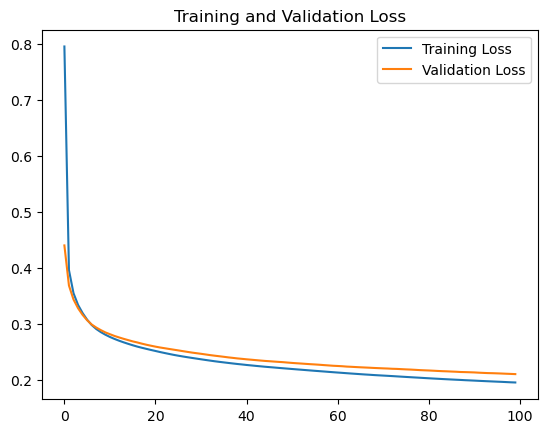

In [141]:
netWrapper_opt.plot_loss()

In [143]:
netWrapper_opt.test_loop(dataloader_train)

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.190990 



(92.82405694582155, 0.19098961537449874)

In [144]:
netWrapper_opt.test_loop(dataloader_val)

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.209854 



(92.18519965147372, 0.20985397643583065)

In [145]:
yt_hat = netWrapper_opt.get_yhat(dataloader_train)
yv_hat = netWrapper_opt.get_yhat(dataloader_val)

Training:  Acc = 0.928
Non-Train: Acc = 0.922
Training:  BalAcc = 0.929
Non-Train: BalAcc = 0.921


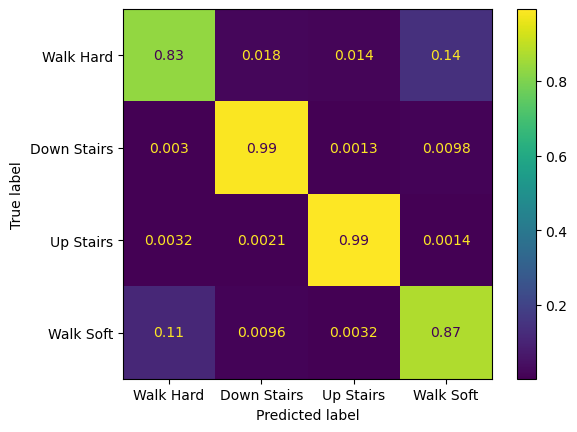

In [146]:
summaryPerf(y_train.cpu().numpy(),yt_hat,y_val.cpu().numpy(),yv_hat)

## Cross Validation

Reference: https://saturncloud.io/blog/how-to-use-kfold-cross-validation-with-dataloaders-in-pytorch/#implementing-k-fold-cross-validation-using-dataloaders-in-pytorch

In [71]:
from sklearn.model_selection import KFold

k_folds = 5
batch_size = 64
momentum, batch_size, nueron1, neuron2 = (0.9, 50, 32, 32)
lr=.0022

kf = KFold(n_splits=k_folds, shuffle=True)

results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")
    print("-------")

    # Define the data loaders for the current fold
    dataset_train = TensorDataset(X_train[train_idx], y_train[train_idx])
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

    dataset_test = TensorDataset(X_train[test_idx], y_train[test_idx])
    test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
    
    temp_net = Net3(neurons_1=nueron1, neurons_2=neuron2)
    temp_net.to(device)
    temp_netWrapper = NetWrapper(temp_net, device, 80, weights, 'sgd', lr=lr, momentum=momentum)
    
    temp_netWrapper.fit(train_loader, batch_size)

    yv_hat = temp_netWrapper.get_yhat(test_loader)
    bal_acc = metrics.balanced_accuracy_score(y_train[test_idx].cpu(), yv_hat)

    results.append((*temp_netWrapper.test_loop(test_loader), bal_acc))

Fold 1
-------
Epoch 1
-------------------------------
loss: 1.147409
Epoch 2
-------------------------------
loss: 0.568520
Epoch 3
-------------------------------
loss: 0.452998
Epoch 4
-------------------------------
loss: 0.414995
Epoch 5
-------------------------------
loss: 0.395287
Epoch 6
-------------------------------
loss: 0.381150
Epoch 7
-------------------------------
loss: 0.370252
Epoch 8
-------------------------------
loss: 0.361570
Epoch 9
-------------------------------
loss: 0.354548
Epoch 10
-------------------------------
loss: 0.348735
Epoch 11
-------------------------------
loss: 0.343649
Epoch 12
-------------------------------
loss: 0.339301
Epoch 13
-------------------------------
loss: 0.335385
Epoch 14
-------------------------------
loss: 0.331870
Epoch 15
-------------------------------
loss: 0.328555
Epoch 16
-------------------------------
loss: 0.325549
Epoch 17
-------------------------------
loss: 0.322885
Epoch 18
-------------------------------
l

In [72]:
results

[(83.87167175905718, 0.2906159134986608, 0.9004462727097473),
 (83.87167175905718, 0.29782102362293267, 0.8899551274281773),
 (83.50065473592318, 0.3022546200486629, 0.8875289309389729),
 (83.34788302051506, 0.2842952109387387, 0.8929705976563169),
 (83.80266317397948, 0.3003916773621155, 0.8948161244320514)]

# Trying with Adam

In [151]:
lr = 0.002154
net_adam = Net3(neurons_1=64, neurons_2=64)
net_adam.to(device)
netWrapper_adam = NetWrapper(net_adam, device, 100, weights, 'adam', lr=lr, weight_decay=0.0025)
netWrapper_adam.fit(dataloader_train, batch_size, val_dataloader=dataloader_val)

Epoch 1
-------------------------------
loss: 0.370786
val_loss: 0.310270
Epoch 2
-------------------------------
loss: 0.298425
val_loss: 0.294069
Epoch 3
-------------------------------
loss: 0.286476
val_loss: 0.287536
Epoch 4
-------------------------------
loss: 0.280236
val_loss: 0.282957
Epoch 5
-------------------------------
loss: 0.276422
val_loss: 0.280654
Epoch 6
-------------------------------
loss: 0.273743
val_loss: 0.278769
Epoch 7
-------------------------------
loss: 0.271488
val_loss: 0.276251
Epoch 8
-------------------------------
loss: 0.269509
val_loss: 0.274189
Epoch 9
-------------------------------
loss: 0.268084
val_loss: 0.273329
Epoch 10
-------------------------------
loss: 0.266928
val_loss: 0.272059
Epoch 11
-------------------------------
loss: 0.266156
val_loss: 0.270582
Epoch 12
-------------------------------
loss: 0.265260
val_loss: 0.270587
Epoch 13
-------------------------------
loss: 0.264834
val_loss: 0.269673
Epoch 14
-------------------------

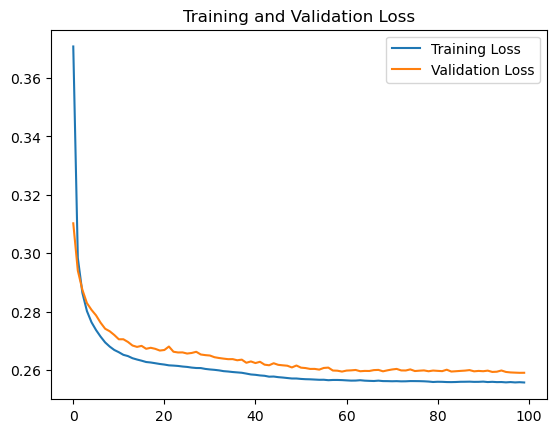

In [152]:
netWrapper_adam.plot_loss()

In [153]:
netWrapper_adam.test_loop(dataloader_train)

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.251701 



(90.49472422417237, 0.25170051657848735)

In [154]:
netWrapper_adam.test_loop(dataloader_val)

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.259118 



(90.25628699335996, 0.25911750819627016)

Training:  Acc = 0.905
Non-Train: Acc = 0.903
Training:  BalAcc = 0.905
Non-Train: BalAcc = 0.902


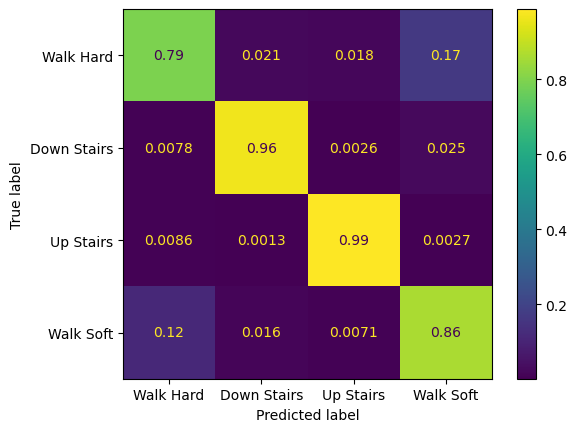

In [155]:
yt_hat = netWrapper_adam.get_yhat(dataloader_train)
yv_hat = netWrapper_adam.get_yhat(dataloader_val)
summaryPerf(y_train.cpu().numpy(),yt_hat,y_val.cpu().numpy(),netWrapper_adam.get_yhat(dataloader_val))

### Trying a deeper fcn

In [85]:
class Net4(nn.Module):
    def __init__(self, num_features=12, hidden_neurons=[32,32,32], num_classes=4, dropout=0.0):
        super().__init__()
        self.input_layer = nn.Linear(num_features, hidden_neurons[0])  # Adjust input size to match the number of features (12)
        self.hiddenlayers = []
    
        for i in range(len(hidden_neurons)-1):
            self.hiddenlayers.append(nn.Linear(hidden_neurons[i], hidden_neurons[i+1]))
            self.hiddenlayers.append(nn.BatchNorm1d(hidden_neurons[i+1]))
            self.hiddenlayers.append(nn.ReLU())
            if dropout != 0.0: self.hiddenlayers.append(nn.Dropout(p=dropout))
        
        self.output_layer = nn.Linear(hidden_neurons[-1], num_classes)

        self.model = nn.Sequential(self.input_layer,*self.hiddenlayers, self.output_layer)


    def forward(self, x):
        return self.model(x)

net4 = Net4(hidden_neurons=[64,32,32,6,4], dropout=0.0)
print(net4)

Net4(
  (input_layer): Linear(in_features=12, out_features=64, bias=True)
  (output_layer): Linear(in_features=4, out_features=4, bias=True)
  (model): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=6, bias=True)
    (8): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=6, out_features=4, bias=True)
    (11): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=4, out_features=4, bias=True)
  )
)


In [75]:
net4 = Net4(hidden_neurons=[32,16,8,6,4], dropout=0.5)
net4.to(device)

batch_size = 64
netWrapper4 = NetWrapper(net4, device, 100, weights, 'adam', lr=.022)
netWrapper4.fit(dataloader_train, batch_size, val_dataloader=dataloader_val)

Epoch 1
-------------------------------
loss: 1.292993
val_loss: 1.184092
Epoch 2
-------------------------------
loss: 1.158115
val_loss: 1.158804
Epoch 3
-------------------------------
loss: 1.146530
val_loss: 1.135578
Epoch 4
-------------------------------
loss: 1.134879
val_loss: 1.155229
Epoch 5
-------------------------------
loss: 1.124557
val_loss: 1.116349
Epoch 6
-------------------------------
loss: 1.148848
val_loss: 1.128653
Epoch 7
-------------------------------
loss: 1.131883
val_loss: 1.135107
Epoch 8
-------------------------------
loss: 1.116373
val_loss: 1.143304
Epoch 9
-------------------------------
loss: 1.131114
val_loss: 1.101289
Epoch 10
-------------------------------
loss: 1.131057
val_loss: 1.123011
Epoch 11
-------------------------------
loss: 1.128834
val_loss: 1.128284
Epoch 12
-------------------------------
loss: 1.117813
val_loss: 1.127072
Epoch 13
-------------------------------
loss: 1.139277
val_loss: 1.118724
Epoch 14
-------------------------

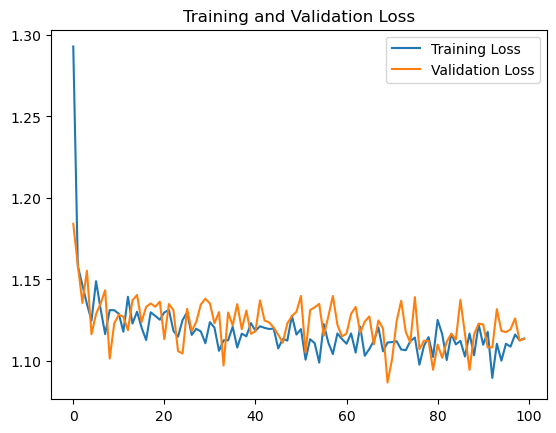

In [81]:
netWrapper4.plot_loss()

In [82]:
netWrapper4.test_loop(dataloader_train)

Test Error: 
 Accuracy: 22.6%, Avg loss: 0.860454 



(22.589375354664107, 0.8604539208239017)

In [83]:
netWrapper4.test_loop(dataloader_val)

Test Error: 
 Accuracy: 22.5%, Avg loss: 0.868781 



(22.490031014621177, 0.8687813477327595)

In [84]:
yt_hat = netWrapper4.get_yhat(dataloader_train)
yv_hat = netWrapper4.get_yhat(dataloader_val)

Training:  Acc = 0.226
Non-Train: Acc = 0.225
Training:  BalAcc = 0.549
Non-Train: BalAcc = 0.547


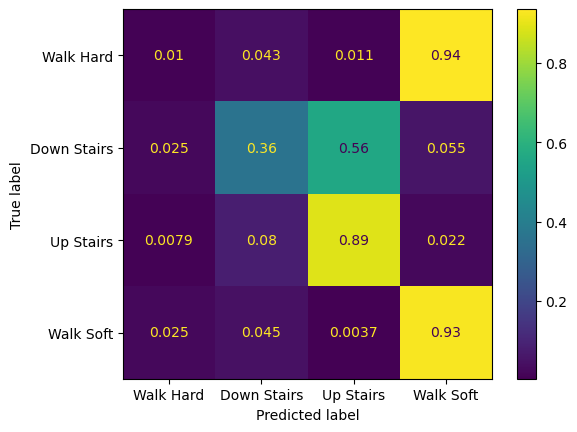

In [80]:
summaryPerf(y_train.cpu().numpy(),yt_hat,y_val.cpu().numpy(),yv_hat)

In [50]:
model = nn.Sequential(
   nn.Conv1d(1, 32, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.MaxPool1d(2,2),
)

print(X_train.unsqueeze(1).shape)
model(X_train.unsqueeze(1)[5,:,:].cpu())


torch.Size([27378, 1, 12])


tensor([[4.2940, 2.7271, 0.0000, 0.5941, 1.0010],
        [0.0000, 0.8144, 1.7095, 0.0000, 0.1993],
        [6.3565, 2.7210, 0.0000, 2.3773, 2.1403],
        [0.0000, 0.8607, 0.0000, 0.0000, 0.0000],
        [1.9950, 0.5983, 2.1058, 2.3401, 1.1444],
        [0.0000, 0.2281, 0.8556, 0.0000, 0.0000],
        [0.0000, 0.5521, 2.4133, 0.0000, 0.0831],
        [0.0000, 0.4093, 1.3050, 0.0000, 0.0000],
        [0.0000, 0.1828, 0.0000, 0.0000, 0.0000],
        [3.6409, 0.5536, 1.3687, 0.2435, 0.1585],
        [0.0000, 0.0000, 1.4427, 0.0000, 0.0000],
        [2.9290, 0.0000, 1.8826, 0.6385, 0.0000],
        [2.6821, 2.9235, 0.1994, 0.4095, 0.9071],
        [1.8089, 0.9994, 0.0206, 0.7077, 0.7254],
        [1.4847, 1.7805, 0.6857, 0.5786, 0.6162],
        [0.0000, 0.3440, 0.0000, 0.0000, 0.0000],
        [2.1385, 0.8877, 0.0000, 0.0000, 0.0000],
        [3.0503, 2.6942, 0.0000, 0.3590, 0.7968],
        [1.3144, 2.1744, 0.4766, 0.0113, 0.4542],
        [0.9000, 1.7790, 1.6393, 0.8717, 0.6514],


In [51]:
class NetCNN(nn.Module):
    def __init__(self, num_features=12, neurons_1 = 64, neurons_2 = 32, num_classes=4):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            )
        self.fc1 = nn.Linear(num_features, neurons_1)  # Adjust input size to match the number of features (12)
        self.fc2 = nn.Linear(neurons_1, neurons_2)
        self.fc3 = nn.Linear(neurons_2, num_classes)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [56]:
model = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            )

test_d = X_train.unsqueeze(1)[0,:,:].cpu()
model(test_d)

tensor([[0.0000e+00, 3.9026e-01, 1.0779e-01, 0.0000e+00, 0.0000e+00],
        [2.8686e+00, 2.2892e+00, 3.9151e+00, 5.3883e+00, 2.9047e+00],
        [1.7892e+00, 1.8414e-01, 2.4767e+00, 1.4081e+00, 2.6442e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.5012e+00, 2.6312e+00, 0.0000e+00, 1.7156e+00, 2.1862e+00],
        [0.0000e+00, 1.2284e+00, 1.3401e+00, 0.0000e+00, 2.8975e-01],
        [9.3168e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0165e+00, 5.4419e-02, 1.1037e+00, 0.0000e+00, 0.0000e+00],
        [6.4876e-01, 5.6103e-01, 4.5668e-02, 4.1549e-01, 5.1621e-01],
        [1.2859e+00, 1.6620e+00, 0.0000e+00, 0.0000e+00, 6.1329e-01],
        [7.9569e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2423e+00, 2.9722e+00, 1.2622e+00, 1.7695e+00, 1.8002e+00],
        [1.1589e+00, 0.0000e+00, 6.9928e-02, 0.0000e+00, 0.0000e+00],
        [3.1254e+00,

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 3, 128)  
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.batchnorm4 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 4)  
        

    def forward(self, x):
        # Apply convolutional layers
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 32 * 3)  # Adjust the size based on the output size of the conv layers
        
        # Apply fully connected layers
        x = F.relu(self.batchnorm3(self.fc1(x)))
        x = F.relu(self.batchnorm4(self.fc2(x)))
        x = self.fc3(x)
        
        return x




In [123]:
cnet = ConvNet()
wrap = NetWrapper(cnet, device, 50, weights, 'adam', lr=.002,weight_decay=0.01)
wrap.fit(dataloader_train, batch_size, val_dataloader=dataloader_val, conv=True)

Epoch 1
-------------------------------
loss: 0.511045
val_loss: 0.453975
Epoch 2
-------------------------------
loss: 0.431354
val_loss: 0.432031
Epoch 3
-------------------------------
loss: 0.419651
val_loss: 0.425791
Epoch 4
-------------------------------
loss: 0.409504
val_loss: 0.417428
Epoch 5
-------------------------------
loss: 0.402188
val_loss: 0.422949
Epoch 6
-------------------------------
loss: 0.397146
val_loss: 0.412281
Epoch 7
-------------------------------
loss: 0.393433
val_loss: 0.412666
Epoch 8
-------------------------------
loss: 0.391058
val_loss: 0.412018
Epoch 9
-------------------------------
loss: 0.387321
val_loss: 0.404120
Epoch 10
-------------------------------
loss: 0.384536
val_loss: 0.397394
Epoch 11
-------------------------------
loss: 0.381739
val_loss: 0.403084
Epoch 12
-------------------------------
loss: 0.382635
val_loss: 0.402152
Epoch 13
-------------------------------
loss: 0.378244
val_loss: 0.405079
Epoch 14
-------------------------

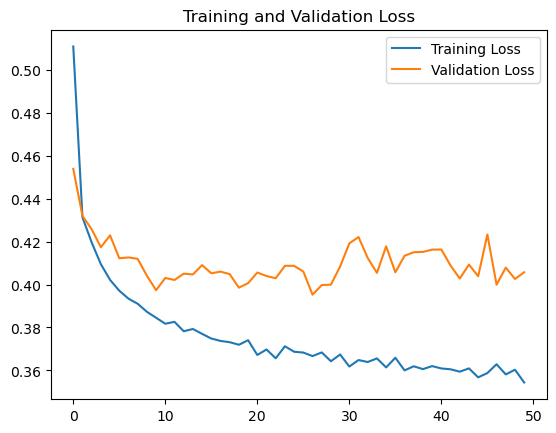

In [124]:
wrap.plot_loss()

In [125]:
yt_hat = wrap.get_yhat(dataloader_train, conv=True)
yv_hat = wrap.get_yhat(dataloader_val, conv=True)

Training:  Acc = 0.810
Non-Train: Acc = 0.817
Training:  BalAcc = 0.867
Non-Train: BalAcc = 0.865


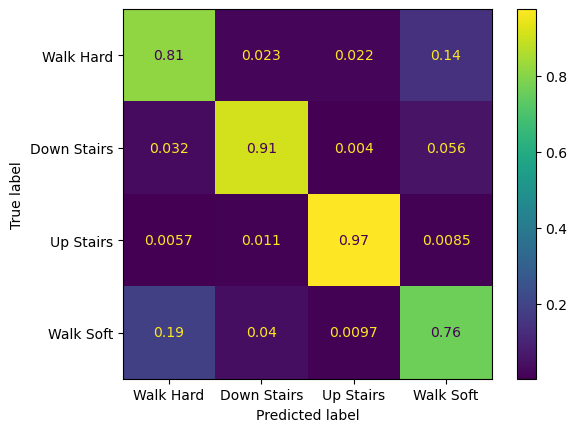

In [126]:
summaryPerf(y_train.cpu().numpy(),yt_hat,y_val.cpu().numpy(),yv_hat)

# Trying an LSTM

In [ ]:
...
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    


# TESTING

In [147]:
# Specifying the data directory
dirTest = './GaitData/data/test/'

# Specifying some parameters for the feature extraction
# Same as before
timeStep = 1
winSz = 2

# Specifying IDs 
testIds = [1,2,3,4]

# Recovering the features and labels
# UNDERSCORES are for useless nans
X1, _, X1_times, y1_times = loadFeatures(dirTest,winSz,timeStep,[1])
X2, _, X2_times, y2_times = loadFeatures(dirTest,winSz,timeStep,[2])
X3, _, X3_times, y3_times  = loadFeatures(dirTest,winSz,timeStep,[3])
X4, _, X4_times, y4_times = loadFeatures(dirTest,winSz,timeStep,[4])

X1 = scaler.transform(X1)
X1 = torch.from_numpy(X1).to(device).float()

X2 = scaler.transform(X2)
X2 = torch.from_numpy(X2).to(device).float()

X3 = scaler.transform(X3)
X3 = torch.from_numpy(X3).to(device).float()

X4 = scaler.transform(X4)
X4 = torch.from_numpy(X4).to(device).float()

/home/gathomp3/Deep_Learning/NNs/fncs.py:11: RuntimeWarning: invalid value encountered in cast
  yv = y[:,1].astype(int)


### Using tuned NetWrapperOpt

In [148]:
# Pass X1 as tensor to model
with torch.no_grad():
    y1_hat = netWrapper_opt.model(X1)
    y2_hat = netWrapper_opt.model(X2)
    y3_hat = netWrapper_opt.model(X3)
    y4_hat = netWrapper_opt.model(X4)

y1_hat = y1_hat.argmax(1).cpu().numpy()
y2_hat = y2_hat.argmax(1).cpu().numpy()
y3_hat = y3_hat.argmax(1).cpu().numpy()
y4_hat = y4_hat.argmax(1).cpu().numpy()

### Using Adam

In [157]:
# Pass X1 as tensor to model
with torch.no_grad():
    y1_hat_adam = netWrapper_adam.model(X1)
    y2_hat_adam = netWrapper_adam.model(X2)
    y3_hat_adam = netWrapper_adam.model(X3)
    y4_hat_adam = netWrapper_adam.model(X4)

y1_hat_adam = y1_hat_adam.argmax(1).cpu().numpy()
y2_hat_adam = y2_hat_adam.argmax(1).cpu().numpy()
y3_hat_adam = y3_hat_adam.argmax(1).cpu().numpy()
y4_hat_adam = y4_hat_adam.argmax(1).cpu().numpy()

Training:  Acc = 0.773
Non-Train: Acc = 0.594
Training:  BalAcc = 0.818
Non-Train: BalAcc = 0.712


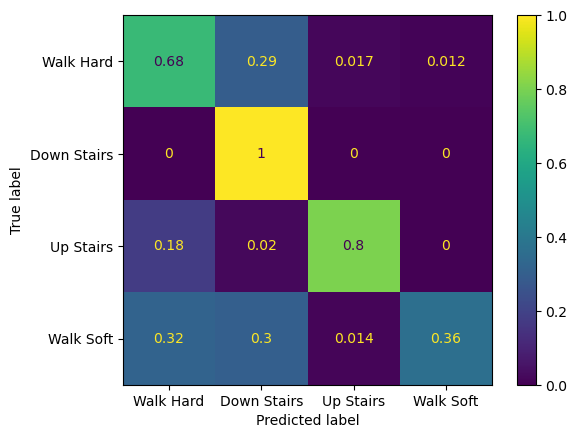

In [158]:
summaryPerf(y2_hat,y2_hat_adam,y4_hat,y4_hat_adam)

Upload to csv file.

In [159]:
import pandas as pd

# Read columns to be filled

df1nan = pd.read_csv(dirTest + f'Trial01_y.csv',header=None)
df1nan.columns = ['time','label']
df1nan['time'] = df1nan['time'].round(2)

df2nan = pd.read_csv(dirTest + f'Trial02_y.csv',header=None)
df2nan.columns = ['time','label']
df2nan['time'] = df2nan['time'].round(2)

df3nan = pd.read_csv(dirTest + f'Trial03_y.csv',header=None)
df3nan.columns = ['time','label']
df3nan['time'] = df3nan['time'].round(2)

df4nan = pd.read_csv(dirTest + f'Trial04_y.csv',header=None)
df4nan.columns = ['time','label']
df4nan['time'] = df4nan['time'].round(2)


In [160]:
df1nan

,time,label
0,0.02,NaN
1,0.12,NaN
2,0.22,NaN
3,0.32,NaN
4,0.42,NaN
...,...,...
8572,857.22,NaN
8573,857.32,NaN
8574,857.42,NaN
8575,857.52,NaN


In [161]:
def concat_time_to_labels(ytimes, ylabels):
    df_y = pd.concat([pd.DataFrame(ytimes), pd.DataFrame(ylabels)], axis=1)
    df_y.columns = ['time', 'label']
    return df_y

# Rounding times for outer join later
y1_timelabels = concat_time_to_labels(y1_times, y1_hat)
y1_timelabels["time"] = y1_timelabels["time"].round(2)

y2_timelabels = concat_time_to_labels(y2_times, y2_hat)
y2_timelabels["time"] = y2_timelabels["time"].round(2)

y3_timelabels = concat_time_to_labels(y3_times, y3_hat)
y3_timelabels["time"] = y3_timelabels["time"].round(2)

y4_timelabels = concat_time_to_labels(y4_times, y4_hat)
y4_timelabels["time"] = y4_timelabels["time"].round(2)

In [162]:
y4_timelabels.head()

,time,label
0,1.02,0
1,2.02,0
2,3.02,0
3,4.02,0
4,5.02,0


Now, I need to interpolate values between times

In [163]:
df1nan

,time,label
0,0.02,NaN
1,0.12,NaN
2,0.22,NaN
3,0.32,NaN
4,0.42,NaN
...,...,...
8572,857.22,NaN
8573,857.32,NaN
8574,857.42,NaN
8575,857.52,NaN


In [164]:
def interpolate_labels(y_timelabels, dfnan):
    merged_df = pd.merge(y_timelabels, dfnan, on='time', how='outer', suffixes=('_1sec', '_01sec'))

    # Step 2: Forward fill to propagate the last known categorical label
    merged_df['label'] = merged_df['label_1sec'].fillna(method='ffill')

    # Step 3: Backward fill to propagate the first known categorical label
    merged_df['label'] = merged_df['label'].fillna(method='bfill')

    # Drop redundant columns
    merged_df.drop(['label_1sec', 'label_01sec'], axis=1, inplace=True)

    # Final DataFrame with interpolated categorical labels
    final_df = merged_df[['time', 'label']]
    return final_df

In [165]:
y1_final = interpolate_labels(y1_timelabels, df1nan)
y2_final = interpolate_labels(y2_timelabels, df2nan)
y3_final = interpolate_labels(y3_timelabels, df3nan)
y4_final = interpolate_labels(y4_timelabels, df4nan)

/tmp/ipykernel_59938/3767688155.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['label'] = merged_df['label_1sec'].fillna(method='ffill')
/tmp/ipykernel_59938/3767688155.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['label'] = merged_df['label'].fillna(method='bfill')
/tmp/ipykernel_59938/3767688155.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['label'] = merged_df['label_1sec'].fillna(method='ffill')
/tmp/ipykernel_59938/3767688155.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['label'] = merged_df['label'].fillna(method='bfill')
/tmp/ipykernel_59938/3767688155.py:5: FutureWa

In [166]:
"""
save_path = f"./GaitData/data/saved_data/Trial01_y.csv"
y1_final.to_csv(save_path, index=False, header=False)

save_path = f"./GaitData/data/saved_data/Trial02_y.csv"
y2_final.to_csv(save_path, index=False, header=False)

save_path = f"./GaitData/data/saved_data/Trial03_y.csv"
y3_final.to_csv(save_path, index=False, header=False)

save_path = f"./GaitData/data/saved_data/Trial04_y.csv"
y4_final.to_csv(save_path, index=False, header=False)
"""